# Model Building
### Cory Clayton, Emily Lien, Prabhjot Singh

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
import sklearn
import sklearn.preprocessing
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from datetime import datetime
from numpy import concatenate
import matplotlib as mpl

Data was cleaned in the data cleaning notebook. In Part 4 and 5, the cleaned csv was read in and various models were build. These models include:
* LSTM
* RNN
* Deep LSTM
* Deep RNN

Following this, in Part 6 the model were tuned. This section specifically focused on attemtpting to improve the model via the hyperparameters. Regularization tactics included the integration of dropout and batch normlalization. 

In [54]:
#read in the data
hourly = pd.read_csv('wind_cleaned.csv',index_col='DATE')

In [55]:
split_fraction = 0.715   #train / validation split
train_split = int(split_fraction * int(hourly.shape[0]))
step = 1   #used if you want to skip hours

past = 120  #number of past hours to look at
future = 1  #how many hours in the future to predict
learning_rate = 0.001
batch_size = 32
epochs = 10

#normalize the data
def normalize(data, train_split):                 
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [56]:
hourly

,wnd_speed,temp_change,hourly_liq_depth_dim,liq_depth_dim,fan_speed,fan_speed2,fan_speed3,rh_air_temp,rel_humiditiy,min_hourly_air_temp,...,min_solar_rad,max_solar_rad,std_solar_rad,surface_temp,std_surface_temp,ex_air_temp,ex_air_temp_2,hourly_gust,wind_std,hour
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,23,75,0,0,816,959,1102,77,412,77,...,0,0,0,81,3,89,75,47,65,0
2020-01-01 01:00:00,18,63,0,0,813,957,1099,64,438,63,...,0,0,0,66,4,76,62,56,84,1
2020-01-01 02:00:00,20,59,0,0,811,955,1096,60,443,59,...,0,0,0,57,2,63,58,54,87,2
2020-01-01 03:00:00,30,52,0,0,810,955,1093,53,483,53,...,0,0,0,56,2,61,52,70,98,3
2020-01-01 04:00:00,24,49,0,0,808,953,1091,49,506,47,...,0,0,0,47,2,54,46,56,94,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,19,113,0,0,886,1019,1185,113,721,105,...,1130,5483,794,130,8,114,105,34,54,19
2020-12-31 20:00:00,15,104,0,0,866,999,1160,105,714,105,...,559,4638,913,140,13,118,104,37,62,20
2020-12-31 21:00:00,13,98,0,0,819,957,1102,98,724,98,...,263,621,96,108,5,104,97,36,58,21


In [57]:
features = normalize(hourly.values, train_split)  #extract the features normalized
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.666842,-0.889331,-0.031372,-0.025799,-0.563459,-0.404292,-0.518017,-0.876069,-1.111618,-0.819877,...,-0.544143,-0.729012,-0.61152,-0.883275,-0.388901,-0.789128,-0.484175,0.443108,0.183482,-1.660325
1,0.107474,-1.026942,-0.031372,-0.025799,-0.655199,-0.472108,-0.592012,-1.024685,-0.990544,-0.980986,...,-0.544143,-0.729012,-0.61152,-1.034583,-0.185799,-0.937480,-0.569980,0.922227,0.887507,-1.515821
2,0.331221,-1.072812,-0.031372,-0.025799,-0.716359,-0.539925,-0.666008,-1.070413,-0.967260,-1.027017,...,-0.544143,-0.729012,-0.61152,-1.125368,-0.592002,-1.085833,-0.596381,0.815756,0.998669,-1.371317
3,1.449957,-1.153085,-0.031372,-0.025799,-0.746939,-0.539925,-0.740004,-1.150437,-0.780992,-1.096063,...,-0.544143,-0.729012,-0.61152,-1.135456,-0.592002,-1.108656,-0.635983,1.667522,1.406263,-1.226813
4,0.778715,-1.187488,-0.031372,-0.025799,-0.808098,-0.607742,-0.789334,-1.196165,-0.673888,-1.165110,...,-0.544143,-0.729012,-0.61152,-1.226240,-0.592002,-1.188538,-0.675585,0.922227,1.258047,-1.082309


In [58]:
train_data = features.loc[0 : train_split - 1]  #split the data
val_data = features.loc[train_split:]

In [59]:
start = past + future   #set the start and end of the for looking to the future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[0]]  #get the first column (wind) as response

sequence_length = int(past / step) #used if skipping hours

In [60]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)     #set up a time series dataset

In [61]:
x_end = len(val_data) - past - future    #accounting for previous data

label_start = train_split + past + future   

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)  #validation data set


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 120, 31)
Target shape: (32, 1)


In [62]:
y_val.shape

(2383, 1)

In [63]:
x_val.shape

(2383, 31)

### Basic LSTM

In [12]:
#simple model with 32 LSTM layers

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

#set the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 31)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24576     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________


In [13]:
#set an early stopping callback
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


#fit the model
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
193/193 [==============================] - ETA: 0s - loss: 0.6237
Epoch 00001: val_loss improved from inf to 0.64920, saving model to model_checkpoint.h5
193/193 [==============================] - 17s 89ms/step - loss: 0.6237 - val_loss: 0.6492
Epoch 2/10
193/193 [==============================] - ETA: 0s - loss: 0.4664
Epoch 00002: val_loss did not improve from 0.64920
193/193 [==============================] - 18s 96ms/step - loss: 0.4664 - val_loss: 0.7121
Epoch 3/10
193/193 [==============================] - ETA: 0s - loss: 0.4263
Epoch 00003: val_loss did not improve from 0.64920
193/193 [==============================] - 20s 101ms/step - loss: 0.4263 - val_loss: 0.7713
Epoch 4/10
193/193 [==============================] - ETA: 0s - loss: 0.4058
Epoch 00004: val_loss did not improve from 0.64920
193/193 [==============================] - 19s 98ms/step - loss: 0.4058 - val_loss: 0.7539
Epoch 5/10
193/193 [==============================] - ETA: 0s - loss: 0.3933
Epoch 000

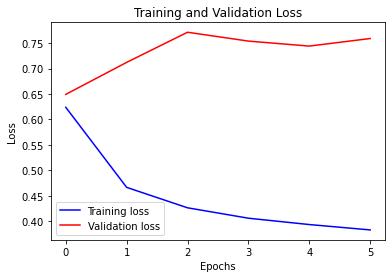

In [14]:
#visualize the loss over epochs

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

ValueError: x and y must have same first dimension, but have shapes (1,) and (120, 10)

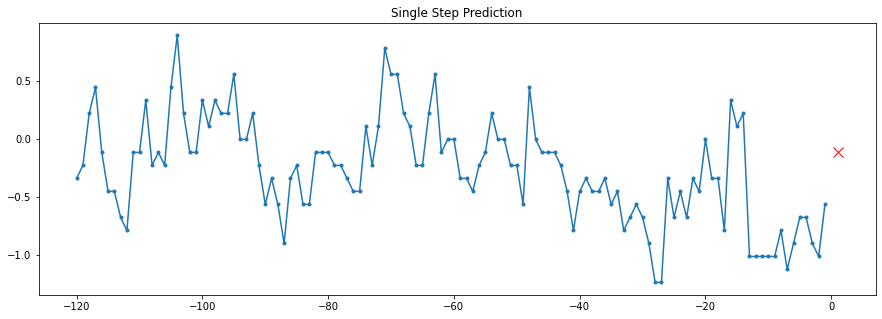

In [48]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [15]:
#A modification of the initial model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(60)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

#set the model
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 31)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                22080     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 22,141
Trainable params: 22,141
Non-trainable params: 0
_________________________________________________________________


In [16]:
#set an early stopping callback
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


#fit the model
history = model2.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
193/193 [==============================] - ETA: 0s - loss: 0.6392
Epoch 00001: val_loss improved from inf to 0.55618, saving model to model_checkpoint.h5
193/193 [==============================] - 8s 44ms/step - loss: 0.6392 - val_loss: 0.5562
Epoch 2/10
192/193 [============================>.] - ETA: 0s - loss: 0.4850
Epoch 00002: val_loss improved from 0.55618 to 0.54816, saving model to model_checkpoint.h5
193/193 [==============================] - 9s 47ms/step - loss: 0.4839 - val_loss: 0.5482
Epoch 3/10
193/193 [==============================] - ETA: 0s - loss: 0.4363
Epoch 00003: val_loss improved from 0.54816 to 0.54663, saving model to model_checkpoint.h5
193/193 [==============================] - 10s 53ms/step - loss: 0.4363 - val_loss: 0.5466
Epoch 4/10
193/193 [==============================] - ETA: 0s - loss: 0.4133
Epoch 00004: val_loss improved from 0.54663 to 0.53404, saving model to model_checkpoint.h5
193/193 [==============================] - 11s 56ms/step 

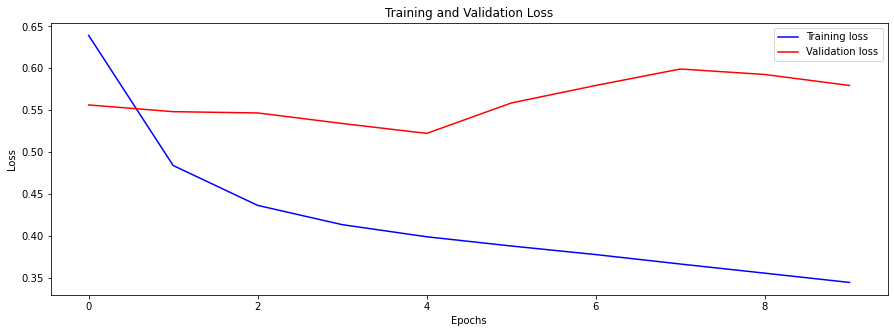

In [50]:
#visualize the loss over epochs

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

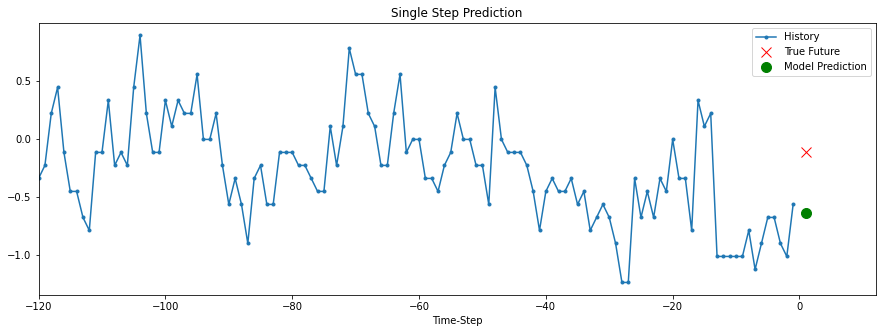

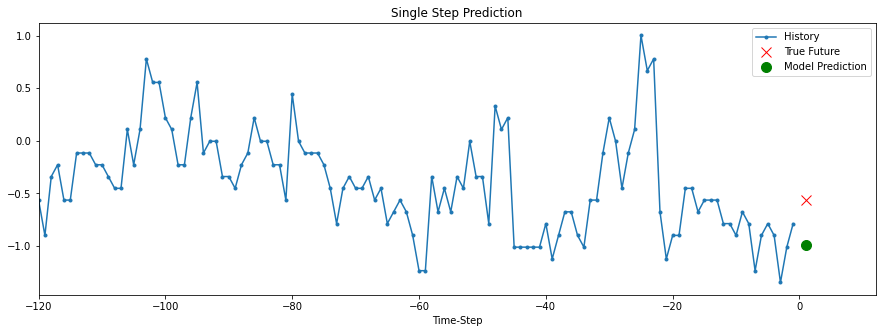

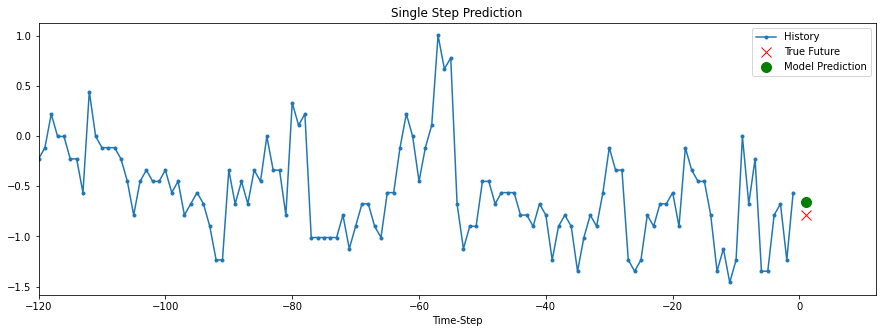

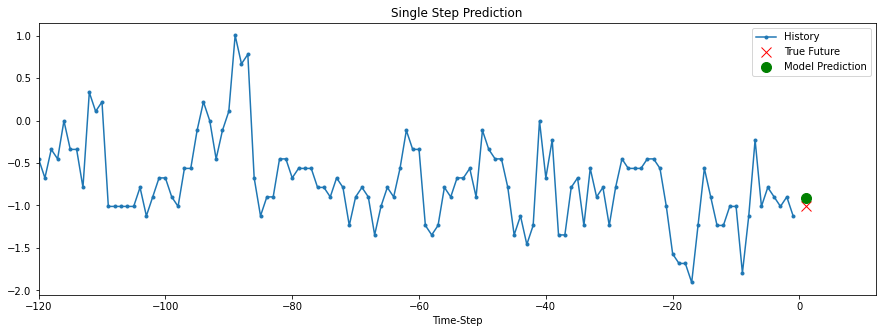

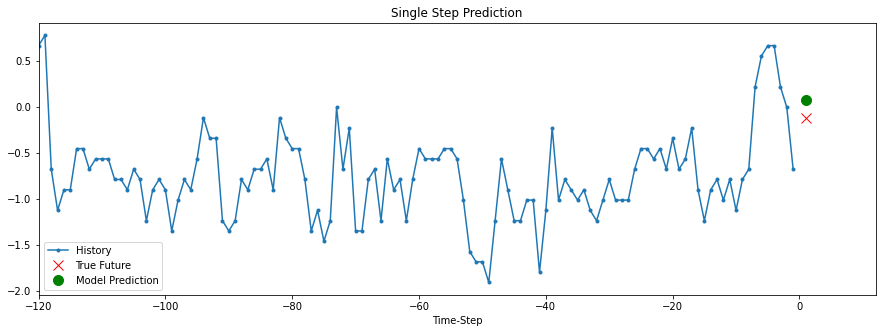

In [30]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model2.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

### Deep LSTM 1 -- Recreating based on Another Approach

In [31]:
#Recreating the model from https://github.com/balandhanka/Windspeed-Forecasting-LSTM-GRU/blob/master/final_lstm.ipynb

In [69]:
def create_ts_data(dataset, lookback=1, predicted_col=3):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [70]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(features, 1,3)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)','var6(t-1)','var7(t-1)','var8(t-1)',
                      'var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)',
                      'var17(t-1)','var18(t-1)','var19(t-1)','var20(t-1)','var21(t-1)','var22(t-1)','var23(t-1)','var24(t-1)',
                      'var25(t-1)','var26(t-1)','var27(t-1)','var28(t-1)','var29(t-1)','var30(t-1)','var31(t-1)','var32(t-1)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    0.666842  -0.889331  -0.031372  -0.025799  -0.563459  -0.404292   
2    0.107474  -1.026942  -0.031372  -0.025799  -0.655199  -0.472108   
3    0.331221  -1.072812  -0.031372  -0.025799  -0.716359  -0.539925   
4    1.449957  -1.153085  -0.031372  -0.025799  -0.746939  -0.539925   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var23(t-1)  var24(t-1)  \
id                                               ...                           
1   -0.518017  -0.876069  -1.111618   -0.819877  ...   -0.729012    -0.61152   
2   -0.592012  -1.024685  -0.990544   -0.980986  ...   -0.729012    -0.61152   
3   -0.666008  -1.070413  -0.967260   -1.027017  ...   -0.729012    -0.61152   
4   -0.740004  -1.150437  -0.780992   -1.096063  ...   -0.729012    -0.61152   

    var25(t-1)  var26(t-1)  var27(t-1)  var28(t-1)  var29(t-1)  var30(t-1)  \
id      

In [71]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(hourly) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]



In [72]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6148, 1, 31) (6148,) (2635, 1, 31) (2635,)


In [78]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mse', optimizer='adam')

In [79]:
model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 1, 75)             32100     
_________________________________________________________________
lstm_26 (LSTM)               (None, 1, 30)             12720     
_________________________________________________________________
lstm_27 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 52,171
Trainable params: 52,171
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_lstm.compile(loss='mse', optimizer='adam')
lstm_history = model_lstm.fit(train_X, train_y, epochs=10,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/10
97/97 [==============================] - 2s 17ms/step - loss: 1.0219 - val_loss: 4.9989e-04
Epoch 2/10
97/97 [==============================] - 0s 4ms/step - loss: 1.0187 - val_loss: 2.6031e-04
Epoch 3/10
97/97 [==============================] - 0s 4ms/step - loss: 1.0103 - val_loss: 6.2905e-04
Epoch 4/10
97/97 [==============================] - 0s 4ms/step - loss: 0.9849 - val_loss: 0.0016
Epoch 5/10
97/97 [==============================] - 0s 4ms/step - loss: 0.9281 - val_loss: 0.0027
Epoch 6/10
97/97 [==============================] - 0s 4ms/step - loss: 0.8564 - val_loss: 0.0021
Epoch 7/10
97/97 [==============================] - 0s 4ms/step - loss: 0.7974 - val_loss: 0.0013
Epoch 8/10
97/97 [==============================] - 0s 4ms/step - loss: 0.7554 - val_loss: 0.0011
Epoch 9/10
97/97 [==============================] - 0s 4ms/step - loss: 0.7251 - val_loss: 9.2207e-04
Epoch 10/10
97/97 [==============================] - 0s 4ms/step - loss: 0.7006 - val_loss: 0.0014


In [83]:
pred_y =  model_lstm.evaluate(test_X)

83/83 [==============================] - 0s 719us/step - loss: 0.0000e+00


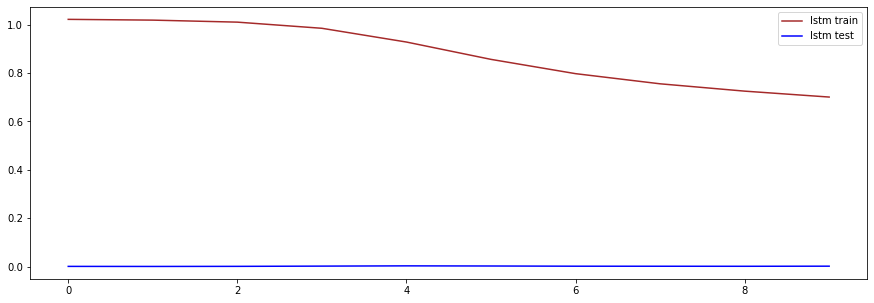

In [82]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [42]:
test_y.reshape(2635,1)

array([[-0.02579926],
       [-0.02579926],
       [-0.02579926],
       ...,
       [-0.02579926],
       [-0.02579926],
       [-0.02579926]])

In [43]:
pred_y

array([[-0.02612374],
       [-0.02612132],
       [-0.02614242],
       ...,
       [-0.02588367],
       [-0.02588575],
       [-0.02593128]], dtype=float32)

2.094107541057569e-05
-0.02965799524279844
0.004576141978848087
0.0009094030408406897


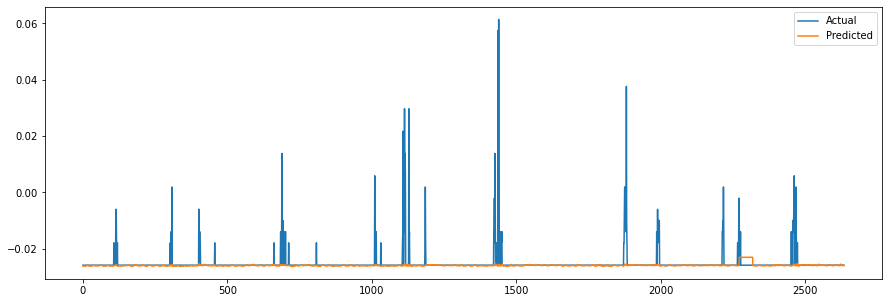

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

In [10]:
#Recreating some of the RNNs from the M7_3 tutorial

y_pred = x_val[:, -1]
np.mean(keras.losses.mean_squared_error(y_val, y_pred))

1.8505681231851796

### Basic RNN

In [ ]:
#Back to basics. Let's try a simple RNN

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

modelR = keras.models.Sequential([
    keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.Adam(lr=0.005)
modelR.compile(loss="mse", optimizer=optimizer)
historyR = modelR.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20
193/193 [==============================] - 2s 10ms/step - loss: 0.9972 - val_loss: 0.6643
Epoch 2/20
193/193 [==============================] - 2s 9ms/step - loss: 0.7330 - val_loss: 0.5941
Epoch 3/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6806 - val_loss: 0.5828
Epoch 4/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6689 - val_loss: 0.5802
Epoch 5/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6650 - val_loss: 0.5790
Epoch 6/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6630 - val_loss: 0.5784
Epoch 7/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6619 - val_loss: 0.5780
Epoch 8/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6611 - val_loss: 0.5779
Epoch 9/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6607 - val_loss: 0.5780
Epoch 10/20
193/193 [==============================] - 2s 9ms/step - loss: 0.6605 - val_loss: 0.578

In [80]:
modelR.evaluate(dataset_val)

71/71 [==============================] - 0s 4ms/step - loss: 0.5797


0.5797474384307861

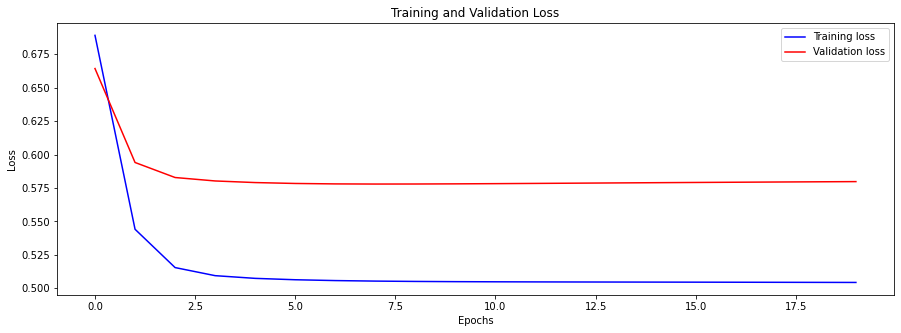

In [91]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyR, "Training and Validation Loss")

### Deep RNN

In [87]:
#Let's try a deep rnn

np.random.seed(42)
tf.random.set_seed(42)

modelDR = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

modelDR.compile(loss="mse", optimizer="adam")
historyDR = modelDR.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

193/193 [==============================] - 8s 43ms/step - loss: 0.8834 - val_loss: 0.7232
Epoch 2/20
193/193 [==============================] - 9s 46ms/step - loss: 0.6431 - val_loss: 0.5462
Epoch 3/20
193/193 [==============================] - 10s 53ms/step - loss: 0.5728 - val_loss: 0.5850
Epoch 4/20
193/193 [==============================] - 10s 52ms/step - loss: 0.5416 - val_loss: 0.5614
Epoch 5/20
193/193 [==============================] - 10s 52ms/step - loss: 0.5245 - val_loss: 0.5483


In [39]:
modelDR.evaluate(dataset_val)

NameError: name 'modelDR' is not defined

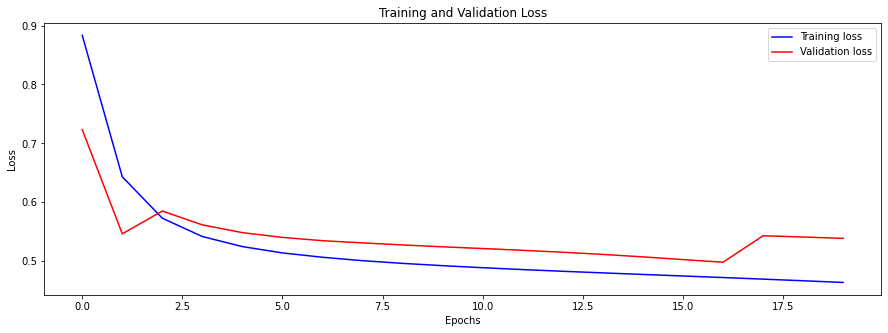

In [95]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyDR, "Training and Validation Loss")

### Deep LSTM

In [64]:
#The deep rnn structure but with LSTM
np.random.seed(42)
tf.random.set_seed(42)

modelLSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(1)
])

modelLSTM.compile(loss="mse", optimizer="adam")
historyLSTM = modelLSTM.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

193/193 [==============================] - 33s 172ms/step - loss: 0.8539 - val_loss: 0.7600
Epoch 2/20
193/193 [==============================] - 33s 169ms/step - loss: 0.7752 - val_loss: 0.7454
Epoch 3/20
193/193 [==============================] - 26s 134ms/step - loss: 0.7259 - val_loss: 0.7301
Epoch 4/20
193/193 [==============================] - 24s 125ms/step - loss: 0.6807 - val_loss: 0.7148
Epoch 5/20
193/193 [==============================] - 29s 153ms/step - loss: 0.6473 - val_loss: 

In [ ]:
modelLSTM.evaluate(dataset_val)

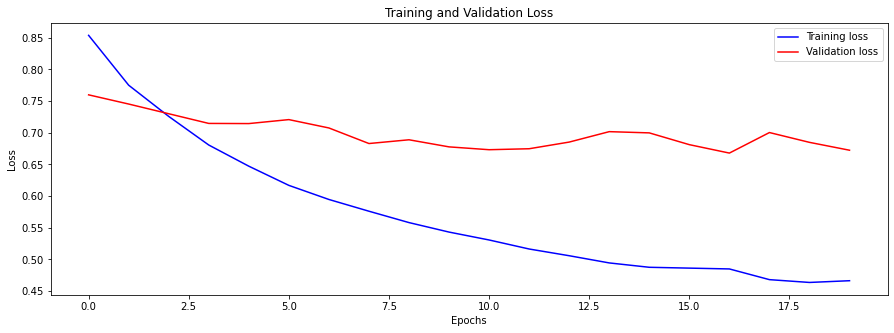

In [97]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyLSTM, "Training and Validation Loss")

## Model Tuning
### Regularization

#### Deep RNN Based off Other Code

In [66]:
#The deep rnn structure but with LSTM
np.random.seed(42)
tf.random.set_seed(42)

modelLSTM_2 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(1)])

modelLSTM_2.compile(loss="mse", optimizer="adam")
historyLSTM_2 = modelLSTM_2.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

193/193 [==============================] - 19s 100ms/step - loss: 0.9249 - val_loss: 0.7940
Epoch 2/20
193/193 [==============================] - 22s 114ms/step - loss: 0.7903 - val_loss: 0.7312
Epoch 3/20
193/193 [==============================] - 22s 115ms/step - loss: 0.7181 - val_loss: 0.7449
Epoch 4/20
193/193 [==============================] - 22s 116ms/step - loss: 0.6540 - val_loss: 0.6987
Epoch 5/20
193/193 [==============================] - 22s 114ms/step - loss: 0.6211 - val_loss: 

In [67]:
modelLSTM_2.evaluate(dataset_val)

71/71 [==============================] - 1s 19ms/step - loss: 0.7416


0.741614043712616

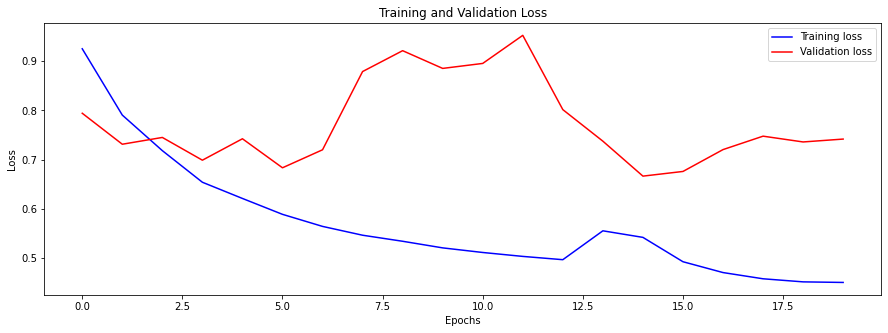

In [86]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyLSTM_2, "Training and Validation Loss")

#### Other Deep LSTM

ModuleNotFoundError: No module named 'keras'

In [91]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

In [95]:
model_lstm.compile(loss='mse', optimizer='adam')
lstm_history = model_lstm.fit(train_X, train_y, epochs=10,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/10
97/97 [==============================] - 1s 12ms/step - loss: 1.0336 - val_loss: 6.3848e-04
Epoch 2/10
97/97 [==============================] - 1s 6ms/step - loss: 1.0107 - val_loss: 9.0753e-04
Epoch 3/10
97/97 [==============================] - 0s 5ms/step - loss: 0.9905 - val_loss: 6.5714e-04
Epoch 4/10
97/97 [==============================] - 0s 4ms/step - loss: 0.9637 - val_loss: 6.2440e-04
Epoch 5/10
97/97 [==============================] - 0s 4ms/step - loss: 0.9269 - val_loss: 0.0011
Epoch 6/10
97/97 [==============================] - 0s 4ms/step - loss: 0.8977 - val_loss: 0.0013
Epoch 7/10
97/97 [==============================] - 0s 4ms/step - loss: 0.8754 - val_loss: 0.0035
Epoch 8/10
97/97 [==============================] - 0s 4ms/step - loss: 0.8574 - val_loss: 0.0146
Epoch 9/10
97/97 [==============================] - 0s 4ms/step - loss: 0.8357 - val_loss: 0.0089
Epoch 10/10
97/97 [==============================] - 0s 4ms/step - loss: 0.8202 - val_loss: 0.0132


## WaveNet Implementation

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

# # mse only at the last time step -- found in textbook 511 
# def last_time_step_mse(Y_true, Y_pred):
#     return keras.metrics.mean_squared_error(Y_true[:-1], Y_pred[:,-1])


# found from pg 522 of textbook
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1,2,4,8)*2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", 
                                 activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [47]:
# # model compiling
# model.compile(loss="mse", optimizer="adam")
# history = model.fit(dataset_train, epochs=20,
#                     validation_data=dataset_val)

This model didn't really work. 

In [ ]:
## Transformers with Time Series Dat